## Tutorial #5: Applying Machine Learning Methods to EEG Data on Group Level

In this tutorial, we are performing the same classification tasks in tutorial named [Applying Machine Learning Methods-1](https://aath0.github.io/AlgorithmsNeuroscience/Tutorial_files/ApplyingMachineLearningMethods_1.html), but this time the analysis is done at the group level, considering EEG data from a group of participants.

##### Dataset: 
In the previous tutorial [Applying Machine Learning Methods-1](ApplyingMachineLearningMethods_1.ipynb),   data of the only one participant in 'Emotion-Antecedent Appraisal Checks: EEG and EMG data sets for Novelty and Pleasantness' is used. 

- In the first part of this tutorial, list of models will be built for each participant separately and then their performances will be compared statistically.

- As of second part, data from all participans will be included while building classifiers. 

### Part - 1:

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [39]:
import mne
from os.path import isfile, join
from os import listdir
import numpy as np
import statistics
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from scipy import stats

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

Loading dataset

In [40]:
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]

#extract ids from file names
ids = [int(f[len(data_folder)+2:-4]) for f in files]

epochs = [mne.read_epochs(f, verbose='error') for f in files]
epochs_UN = [e['FU', 'FN'] for e in epochs]
epochs_UP = [e['FU', 'FP'] for e in epochs]
epochs_NP = [e['FN', 'FP'] for e in epochs]
# Dataset with unpleasant and neutral events
data_UN = [e.get_data() for e in epochs_UN]
labels_UN = [e.events[:,-1] for e in epochs_UN]

data_UP = [e.get_data() for e in epochs_UP]
labels_UP = [e.events[:,-1] for e in epochs_UP]

data_NP = [e.get_data() for e in epochs_NP]
labels_NP = [e.events[:,-1] for e in epochs_NP]

### Example #1:  Classification between Unpleasant and Pleasant Events

We create pipelines for all classifiers and run cross validation for all of them in order to compare their performance:

In [41]:
def applyCrossValidation(models, model_names, data, labels, kfold):
    results = []
    if np.all(np.isfinite(data)) == True and np.any(np.isnan(data)) == False:
        for i in range(len(models)):
            #print(model_names[i])
            cv_accuracy = cross_val_score(models[i], data, labels, cv=kfold)
            results.append(cv_accuracy)
            #print('CV accuracy of model ' + model_names[i] + ': ' + str(cv_accuracy))
            
    else:
        print('Data has infinite or NaN value!')
    
    return results

In [42]:
results_perParticipant_UP = []
model_names = [ 'LR', 'LDA'] 
kfold = StratifiedKFold(n_splits=3, random_state=42)
for i in range(len(ids)):
    # Linear Discriminant Analysis
    clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    #Logistic Regression
    clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
    
    models = [ clf_lr_pip, clf_lda_pip]
    scores = applyCrossValidation(models, model_names, data_UP[i], labels_UP[i], kfold)
    results_perParticipant_UP.append(scores)

Next, we caculate mean of cross validation scores for each model via following function:

In [43]:
def calculateAvgResults(model_names, results_perParticipant):
    avg_results_perParticipant = []
    for i in range(len(ids)):
        score = []
        for j in range(len(model_names)):
            score.append(statistics.mean(results_perParticipant[i][j]))
        avg_results_perParticipant.append(score)  
    
    return avg_results_perParticipant

In [44]:
avg_results_perParticipant_UP = calculateAvgResults(model_names, results_perParticipant_UP)


The following function plots mean cross validation scores of models for each partipant. As it can be observed that classifiers' performances vary depending on the participant.  

In [45]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
def plotCVScores_perParticipant(ids, results, model_names):

    # Fonts for the axis and title
    title_font = {'fontname':'Arial', 'size':'24', 'color':'black', 'weight':'normal'} 
    axis_font = {'fontname':'Arial', 'size':'22'}
    
    width = 0.2  # the width of the bars
    #participants = ['P-'+str(i) for i in unique_ids]
    fig = plt.figure(num=None, figsize=(30, 10), dpi=150)
    # Set position of bar on X axis
    rects1 = np.arange(len(ids))
    rects2 = [x + width for x in rects1]
    
    plt.bar(rects1, list(zip(*results))[0], color='#87CEFA', width=width, edgecolor='white', label=model_names[0])
    plt.bar(rects2, list(zip(*results))[1], color='#FFE4E1', width=width, edgecolor='white', label=model_names[1])

    plt.xticks([r + width/2 for r in range(len(ids))], ids)
    
    plt.xlabel('Participant IDs', **axis_font)
    plt.ylabel('Accuracy', **axis_font)
    plt.title('CV Accuracy Scores per Participant', **title_font)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 20})
    plt.show()

In [46]:
#sort ids results together to plot nicely.
ids_sorted, avg_results_perParticipant_UP = zip(*sorted(zip(ids, avg_results_perParticipant_UP))) 

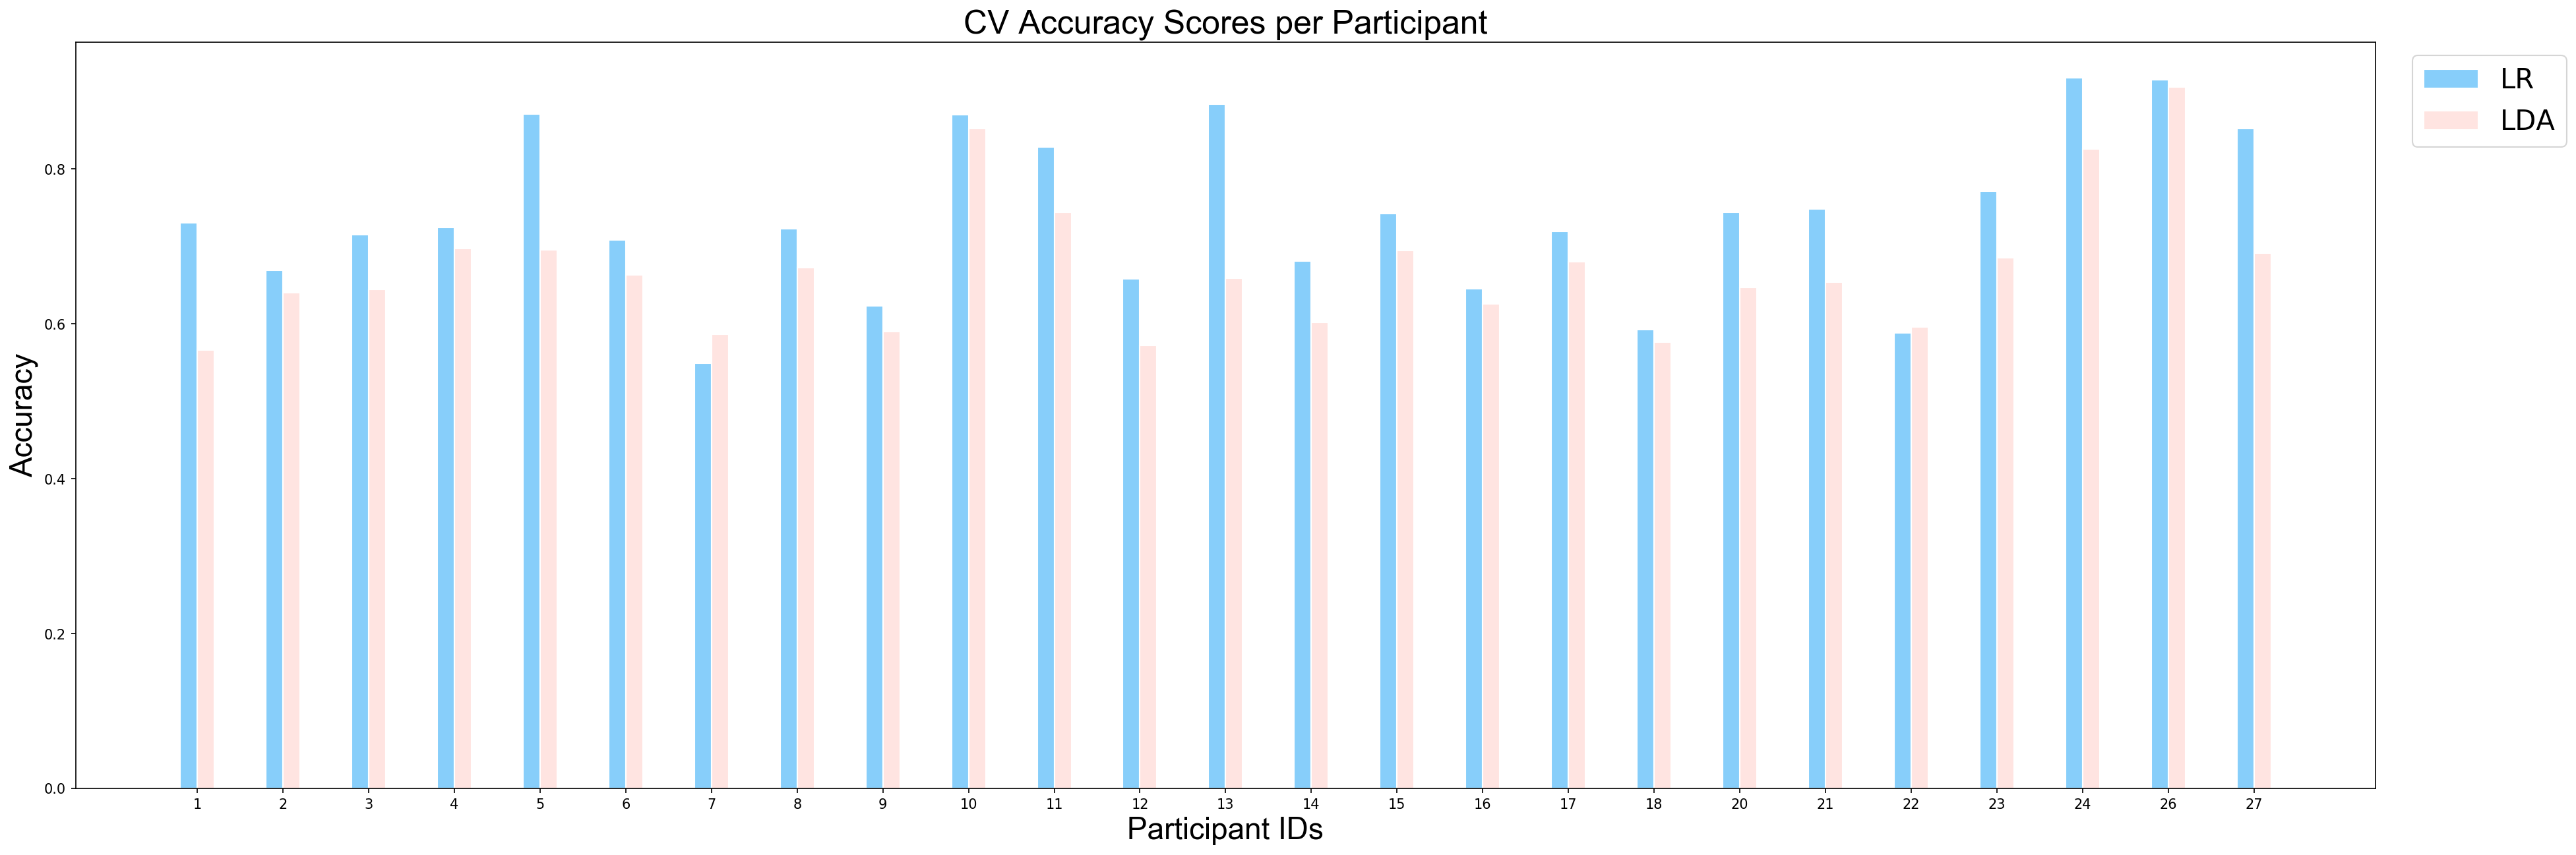

In [47]:
plotCVScores_perParticipant(ids_sorted, avg_results_perParticipant_UP, model_names)

As the final step, a statistical test will be applied to compare models. In machine learning statistical tests can be employed to evaluate whether there is a significant difference between the performace of two classifiers. We choose Wilcoxon test which is a paired non-parametric test. 

Since the same data used for building and testing each classifier, a paired test like Wilcoxon is applicable in our case. Moreover, assumptions for the distributions that will be compared needs to be considered. Since we do not have any assumptions we narrow down our test options to non-parametric test. One can select a parametric test if it is possible to assume which distributon would be observed. 

After deciding the statistical test, a thershold for significance comparison needs to be determined. We consider as significantly different classification performance where statistical tests give a p-value of p < 0.05:

In [48]:
import scipy.stats as stats
def applyStatisticalTest(results, model_names):
    if len(results) < 2:
        print('Not enough values for statistical test!')
    else:
        results = list(zip(*results))
        for i in range(len(results)):
            for j in range(i+1,len(results)):
                t, p = stats.wilcoxon(results[i],results[j])
                print("p = {0} for Wilcoxon test between {1} and {2}".format(p,  model_names[i],  model_names[j]))

In [49]:
applyStatisticalTest(avg_results_perParticipant_UP, model_names)

p = 4.072914334952533e-05 for Wilcoxon test between LR and LDA


Since the derived p-value is smaller than 0.05, we can conclude that there is a significant difference between performance of LDA and performance of LR on the task of classification between unpleasant and pleasant events and Logistic Regression perfomed better in this task.

### Example #2:  Classification between Unpleasant and Neutral Events

Same steps in the first example will be applied for the task of classification between unpleasant and neutral events in this example.

In [50]:
results_perParticipant_UN = []
model_names = [ 'LR', 'LDA'] 
kfold = StratifiedKFold(n_splits=3, random_state=42)
for i in range(len(ids)):
    # Linear Discriminant Analysis
    clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    #Logistic Regression
    clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
    
    models = [ clf_lr_pip, clf_lda_pip]
    scores = applyCrossValidation(models, model_names, data_UN[i], labels_UN[i], kfold)
    results_perParticipant_UN.append(list(scores))

In [51]:
avg_results_perParticipant_UN = calculateAvgResults(model_names, results_perParticipant_UN)
#sort ids results together to plot nicely.
ids_sorted, avg_results_perParticipant_UN = zip(*sorted(zip(ids, avg_results_perParticipant_UN)))  

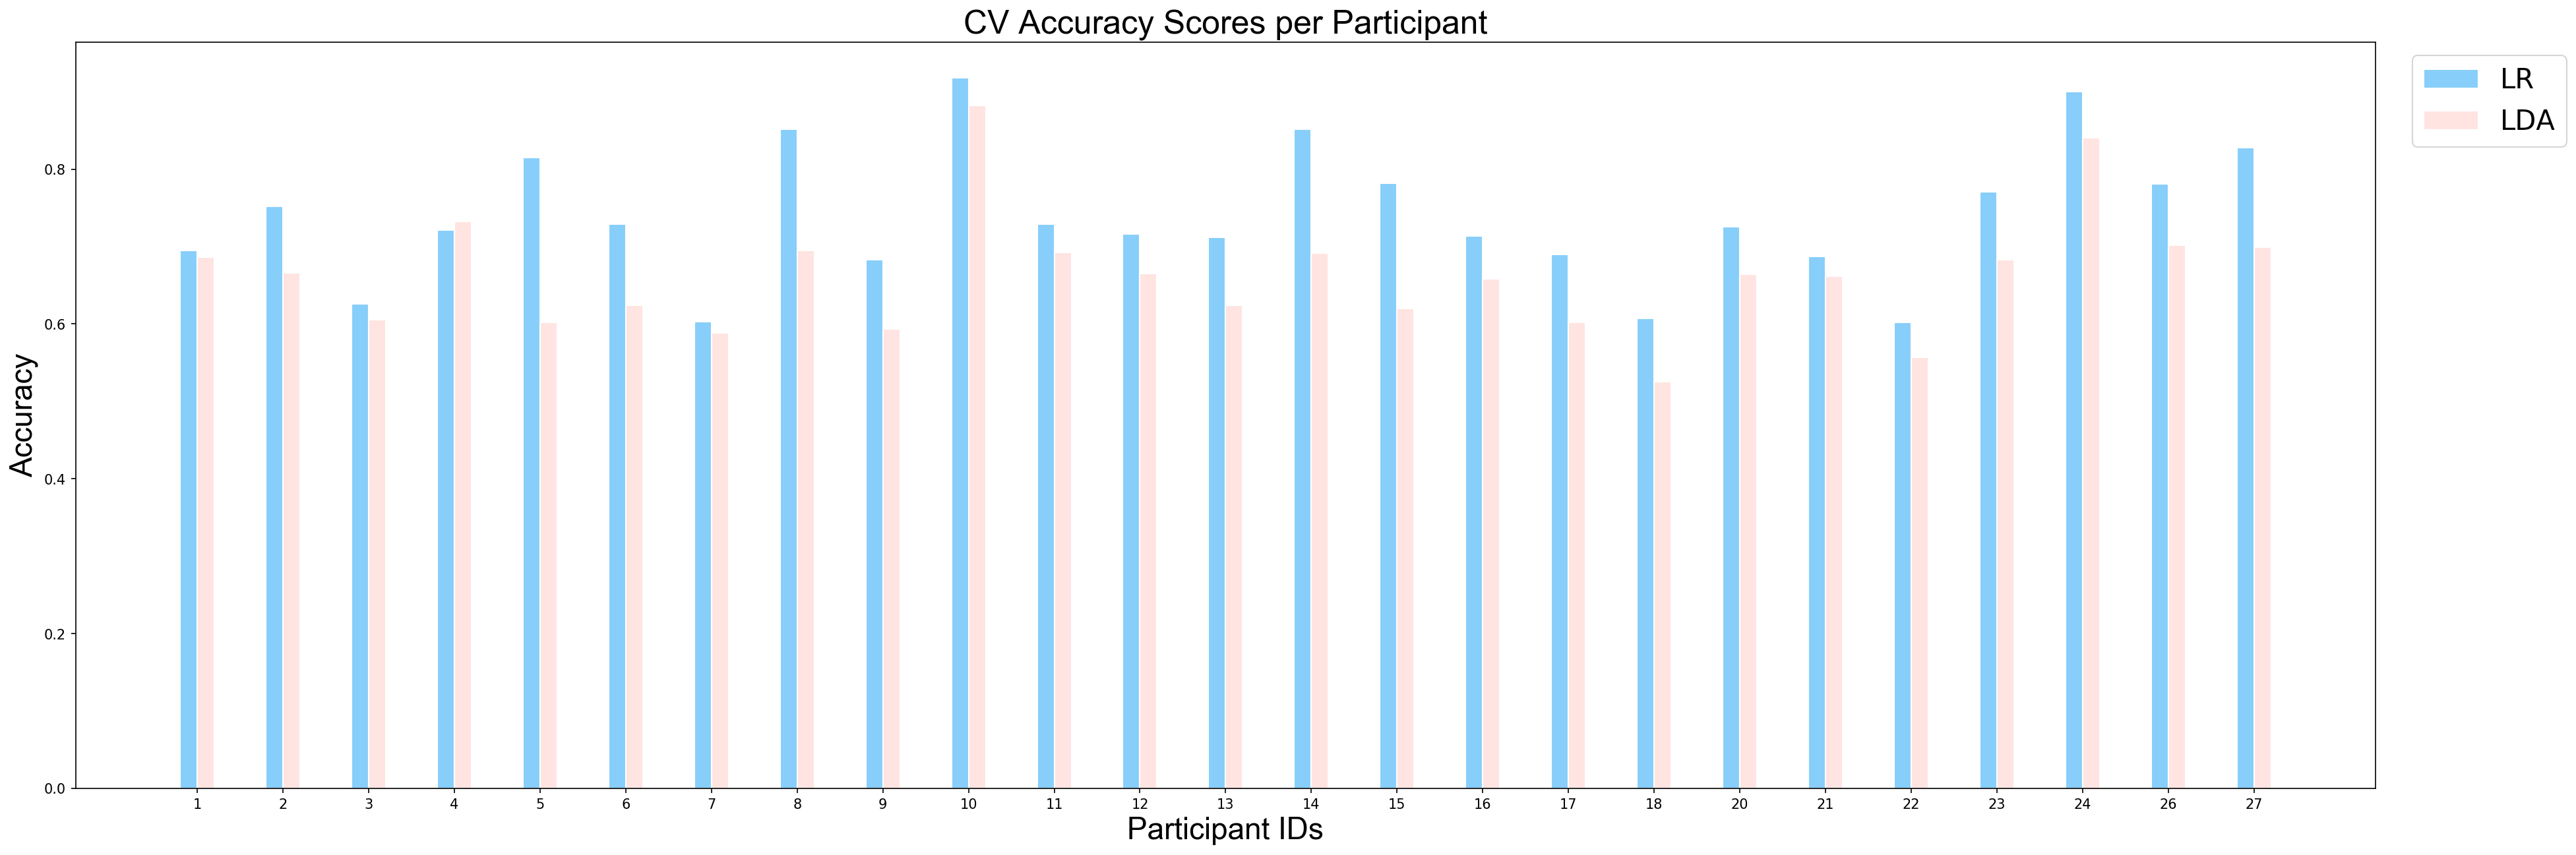

In [52]:
plotCVScores_perParticipant(ids_sorted, avg_results_perParticipant_UN, model_names)

In [53]:
applyStatisticalTest(avg_results_perParticipant_UN, model_names)

p = 1.570510001975002e-05 for Wilcoxon test between LR and LDA


Similar to first example, since the derived p-value is smaller than 0.05, we can conclude that there is a significant difference between performance of LDA and performance of Logistic Regression on the task of classification between unpleasant and neutral events. So, we can conlcude that logistic regression performned better on this task as well.

### Example #3: Classification between Pleasant and Neutral Events

We will follow same steps in the previous examples classification between pleasant and neutral events task in this example.

In [54]:
results_perParticipant_NP = []
model_names = [ 'LR', 'LDA'] 
kfold = StratifiedKFold(n_splits=3, random_state=42)
for i in range(len(ids)):
    # Linear Discriminant Analysis
    clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    #Logistic Regression
    clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
    
    models = [ clf_lr_pip, clf_lda_pip]
    scores = applyCrossValidation(models, model_names, data_NP[i], labels_NP[i], kfold)
    results_perParticipant_NP.append(list(scores))

In [55]:
avg_results_perParticipant_NP = calculateAvgResults(model_names, results_perParticipant_NP)
#sort ids results together to plot nicely.
ids_sorted, avg_results_perParticipant_NP = zip(*sorted(zip(ids, avg_results_perParticipant_NP)))  

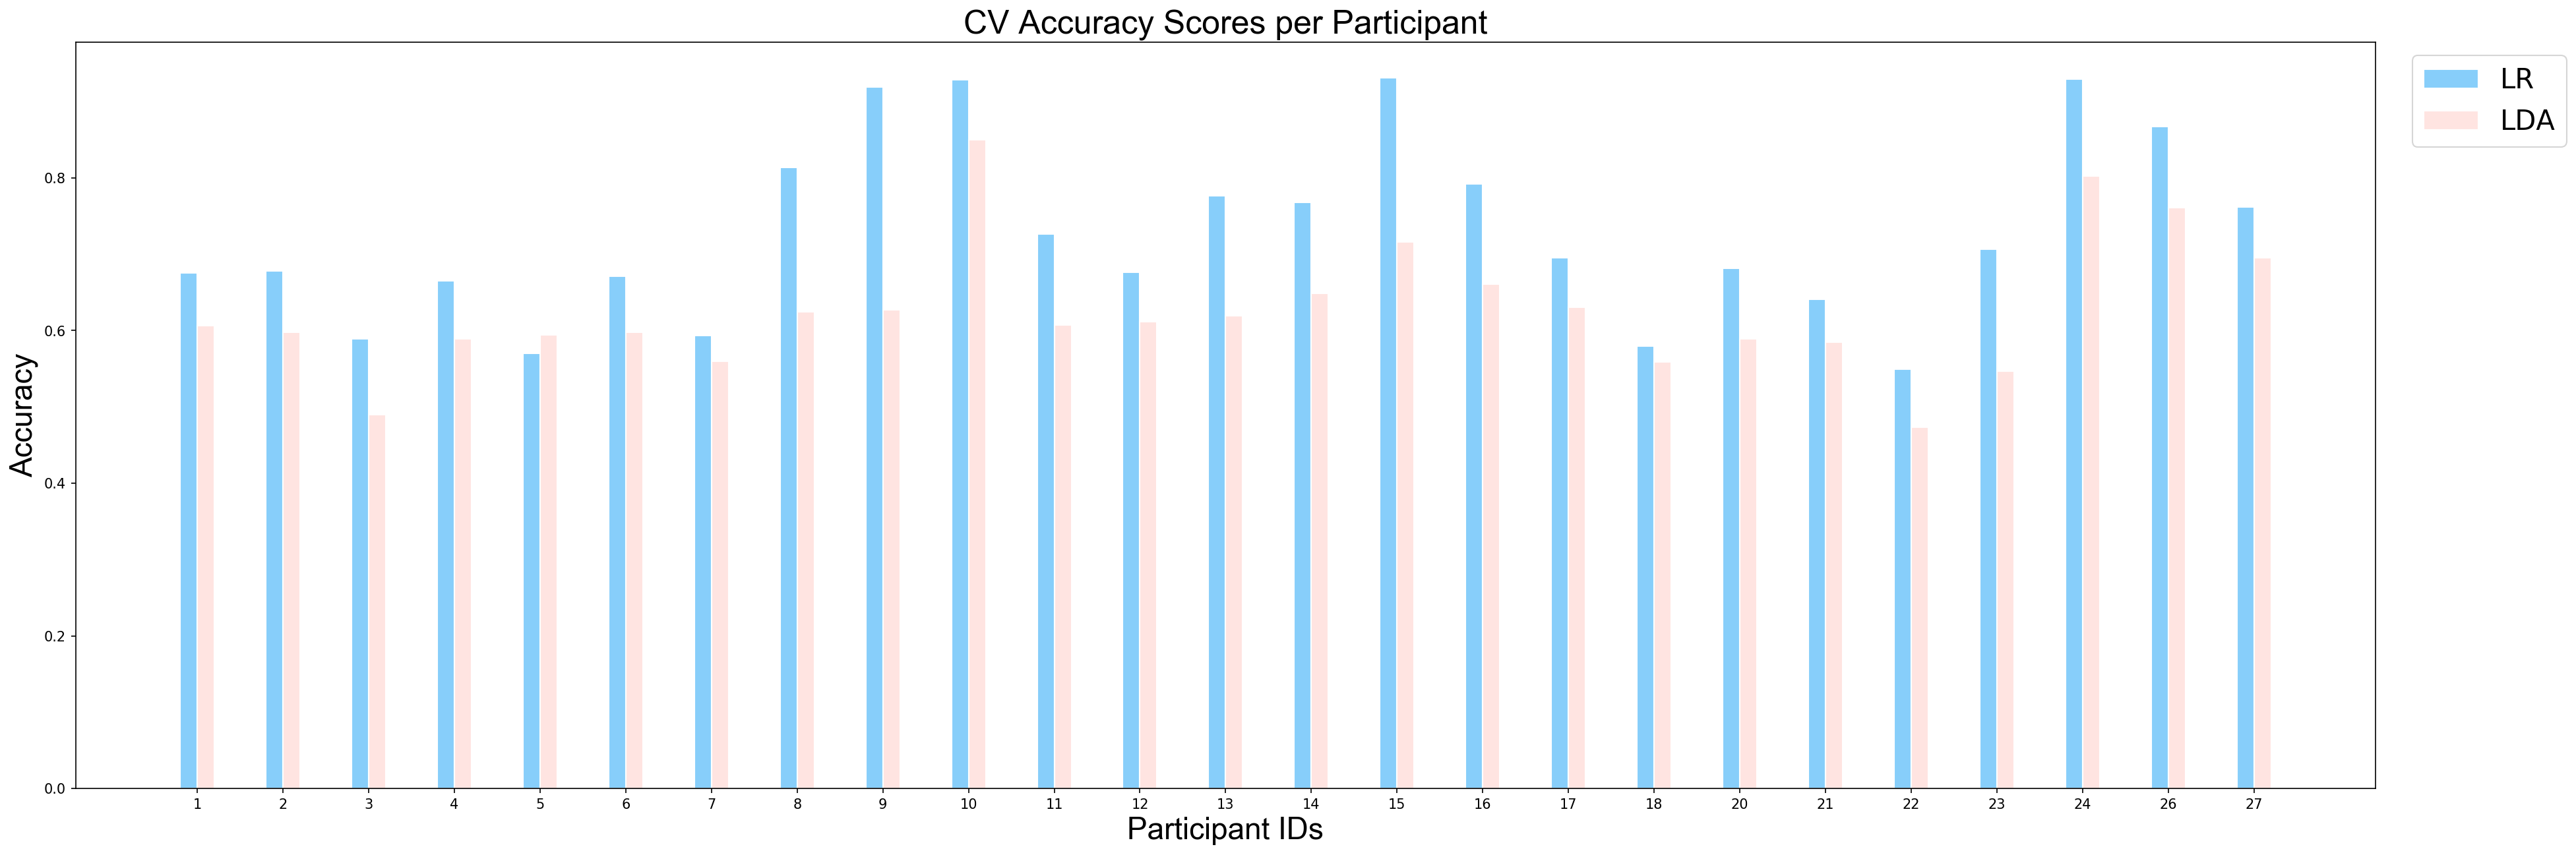

In [56]:
plotCVScores_perParticipant(ids_sorted, avg_results_perParticipant_NP, model_names)

In [57]:
applyStatisticalTest(avg_results_perParticipant_NP, model_names)

p = 1.570510001975002e-05 for Wilcoxon test between LR and LDA


#### Exercise: 

Interpret the p-value derived from Wilcoxon test.

### Part - 2:

In this part, all data will be used for building a model.

In [58]:
#Load and prepare dataset
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]
ids = [int(f[-6:-4]) for f in files]

numberOfEpochs = np.zeros((len(ids), 3))
# Read the EEG epochs:
epochs_all_UN, epochs_all_UP, epochs_all_NP = [], [], []
for f in range(len(files)):
    epochs = mne.read_epochs(files[f], verbose='error')
    epochs_UN = epochs['FU', 'FN']
    epochs_UP = epochs['FU', 'FP']
    epochs_NP = epochs['FN', 'FP']
    numberOfEpochs[f,0] = int(len(epochs_UN.events))
    numberOfEpochs[f,1] = int(len(epochs_UP.events))
    numberOfEpochs[f,2] = int(len(epochs_NP.events))
    UN, UP, NP = [ids[f]], [ids[f]], [ids[f]]
    UN.append(epochs_UN)
    UP.append(epochs_UP)
    NP.append(epochs_NP)
    epochs_all_UN.append(UN)
    epochs_all_UP.append(UP)
    epochs_all_NP.append(NP)

#print(numberOfEpochs)
epochs_all_UN = np.array(epochs_all_UN)
epochs_all_UP = np.array(epochs_all_UP)
epochs_all_NP = np.array(epochs_all_NP)

We define a function that separates data, labels and the IDs of each dataset:

In [59]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1]
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

##### Example: Classification between Unpleasant and Neutral Events¶

In [60]:
data_UN, labels_UN, ids_UN = getData_labels(epochs_all_UN)

We create LDA and logistic regression models as we did in part one. However this time, we will have only two models in total.

In [61]:
#Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))

models = [ clf_lr_pip, clf_lda_pip]
model_names = [ 'LR', 'LDA']
kfold = StratifiedKFold(n_splits=3, random_state=42)

In [62]:
results = applyCrossValidation(models, model_names, data_UN, labels_UN, kfold)

Next, we caculate mean and standard deviation of cross validation scores for each model:

In [64]:
mean_CVaccuracies, std_CVaccuracies = [], []
print('Results UP: {}'.format(results))
mean_CVaccuracies_UN, std_CVaccuracies_UN = [], []
for i in range(len(results)):
    mean_CVaccuracies_UN.append(statistics.mean(results[i]))
    std_CVaccuracies_UN.append(statistics.stdev(results[i]))
print('Mean cv accuracies UP: {}'.format(mean_CVaccuracies_UN))
print('Std cv accuracies UP: {}'.format(std_CVaccuracies_UN))
print('\n')
mean_CVaccuracies.append(mean_CVaccuracies_UN)
std_CVaccuracies.append(std_CVaccuracies_UN)
print('Mean cv accuracies: {}'.format(mean_CVaccuracies))
print('Std cv accuracies: {}'.format(std_CVaccuracies))

Results UP: [array([0.50332284, 0.4926522 , 0.53918824]), array([0.50052466, 0.50174948, 0.52274318])]
Mean cv accuracies UP: [0.5117210960065134, 0.5083391037253356]
Std cv accuracies UP: [0.024378243617145648, 0.012489317029433022]


Mean cv accuracies: [[0.5117210960065134, 0.5083391037253356]]
Std cv accuracies: [[0.024378243617145648, 0.012489317029433022]]


Box plots shows how a given dataset is distributed around the mean of the data and also they highlight outliers:

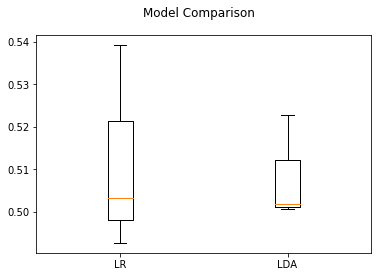

In [65]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plotModelComparison(results, model_names):
    fig = plt.figure()
    fig.suptitle('Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(model_names)
    plt.show()
    
plotModelComparison(results, model_names)

As part of group level analysis of eeg data, LR and LDA are created as in the previous tutorial, [Applying Machine Learning Methods-1](ApplyingMachineLearningMethods_1.ipynb), but this time SVM is omitted because it requires hours to compute given the large amount of data we have at group level. 

The box plot above showed the distibution of cross validation scores for both LDA and Logistic Regression on task of classifying unpleasant and neutral events. While classifying between Unpleasant and Neutral events, both models provided accuracy around 50%. This leads us to the conclusion that considering all participants together does not provided good results. The possible reason might be the variance between participants. 

##### Exercise:

Try building models for other tasks. How do models that are built with all data perform on those tasks? 